# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.387993,False,-2.701408
1,0.349937,True,6.887390
2,-0.794214,False,-0.697657
3,-1.914613,True,4.519245
4,-0.335556,False,0.367590
...,...,...,...
995,-0.107765,True,5.913964
996,-1.662093,True,5.533166
997,-2.019542,False,-1.104075
998,-1.511729,False,-1.661734


<AxesSubplot:xlabel='v0'>

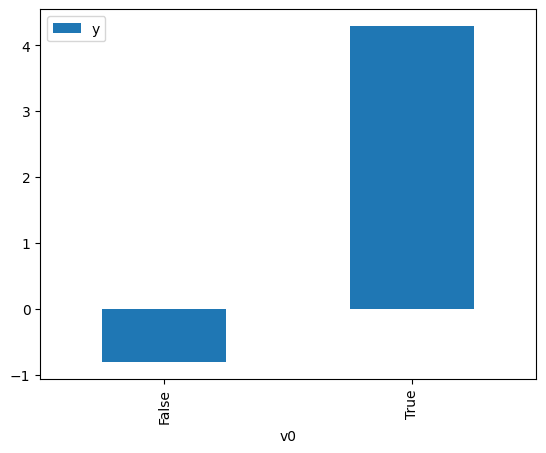

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

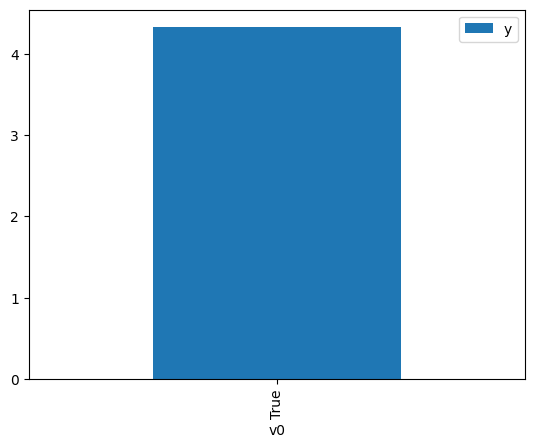

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.096195,False,-1.539132,0.483702,2.067389
1,-2.648642,False,-2.610466,0.695574,1.437662
2,0.566909,False,0.293894,0.445689,2.243716
3,-1.523455,False,-1.802583,0.613215,1.630749
4,-2.087956,False,-0.992591,0.655702,1.525084
...,...,...,...,...,...
995,-0.874294,False,-1.286866,0.562176,1.778801
996,-0.480560,False,0.395871,0.530491,1.885047
997,-1.638826,False,-0.781799,0.622064,1.607551
998,-1.617081,False,-1.892660,0.620402,1.611857


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.747681,True,3.522562,0.369660,2.705188
1,-0.462317,True,3.873671,0.470985,2.123209
2,-1.459731,True,3.896596,0.391705,2.552939
3,0.546305,True,4.519155,0.552657,1.809441
4,-0.443537,True,5.006714,0.472505,2.116378
...,...,...,...,...,...
995,-0.975308,True,3.706193,0.429765,2.326852
996,-0.978049,True,5.303622,0.429547,2.328033
997,-1.894453,True,2.663233,0.358623,2.788446
998,-1.018748,True,4.322951,0.426311,2.345705


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.908
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              4919.
Date:                Thu, 01 Sep 2022   Prob (F-statistic):                        0.00
Time:                        23:20:47   Log-Likelihood:                         -1408.0
No. Observations:                1000   AIC:                                      2820.
Df Residuals:                     998   BIC:                                      2830.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7673      0.023     32.854      0.000       0.721       0.813
x2             5.0991      0.051     99.107      0.000       4.998       5.200
==============================================================================
Omnibus:                        1.887   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.389   Jarque-Bera (JB):                1.840
Skew:                           0.105   Prob(JB):                        0.398
Kurtosis:                       3.011   Cond. No.                         2.45
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""